In [881]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

## I.Import des données ##

In [884]:
# Nettoyage manuel des espaces multiples dans le fichier
file_path = 'c:\\Users\\DF6610\\Documents\\ProjectAppauto\\welddb\\welddb.data'
with open(file_path, 'r') as file:
    cleaned_lines = [' '.join(line.split()) for line in file]

# Conversion des lignes nettoyées en DataFrame

data = pd.read_csv(StringIO('\n'.join(cleaned_lines)), sep=' ', na_values='N',header=None)


In [886]:
# La taille du dataset
print("Le nombre de lignes est: " + str(data.shape[0]))
print("Le nombre de colonnes est: " + str(data.shape[1]))

Le nombre de lignes est: 1652
Le nombre de colonnes est: 44


In [888]:
columns = [
    "Carbon concentration / (weight%)",
    "Silicon concentration / (weight%)",
    "Manganese concentration / (weight%)",
    "Sulphur concentration / (weight%)",
    "Phosphorus concentration / (weight%)",
    "Nickel concentration / (weight%)",
    "Chromium concentration / (weight%)",
    "Molybdenum concentration / (weight%)",
    "Vanadium concentration / (weight%)",
    "Copper concentration / (weight%)",
    "Cobalt concentration / (weight%)",
    "Tungsten concentration / (weight%)",
    "Oxygen concentration / parts per million by weight",
    "Titanium concentration / parts per million by weight",
    "Nitrogen concentration / parts per million by weight",
    "Aluminium concentration / parts per million by weight",
    "Boron concentration / parts per million by weight",
    "Niobium concentration / parts per million by weight",
    "Tin concentration / parts per million by weight",
    "Arsenic concentration / parts per million by weight",
    "Antimony concentration / parts per million by weight",
    "Current / A",
    "Voltage / V",
    "AC or DC",
    "Electrode positive or negative",
    "Heat input / kJ/mm",
    "Interpass temperature / deg C",
    "Type of weld",
    "Post weld heat treatment temperature / deg C",
    "Post weld heat treatment time / hours",
    "Yield strength / MPa",
    "Ultimate tensile strength / MPa",
    "Elongation / %",
    "Reduction of Area / %",
    "Charpy temperature / deg C",
    "Charpy impact toughness / J",
    "Hardness / kg/mm2",
    "50 % FATT",
    "Primary ferrite in microstructure / %",
    "Ferrite with second phase / %",
    "Acicular ferrite / %",
    "Martensite / %",
    "Ferrite with carbide aggregate / %",
    "Weld ID"
]

In [890]:
data.columns=columns
data.head()

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Charpy temperature / deg C,Charpy impact toughness / J,Hardness / kg/mm2,50 % FATT,Primary ferrite in microstructure / %,Ferrite with second phase / %,Acicular ferrite / %,Martensite / %,Ferrite with carbide aggregate / %,Weld ID
0,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aaw
1,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,-28.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aawch
2,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,-38.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aht
3,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Baw
4,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,...,-48.0,100.0,NaN,NaN,32,28.0,40.0,0.0,0.0,Evans-Ni/CMn-1990/1991-0Bawch


## II.Groupement ID ##

In [893]:
# Exemple de DataFrame avec une colonne d'identifiants
data_exple = {
    'ID': ['abcd123', 'abc124', 'abcd125', 'def456', 'def457', 'ghi789', 'ghi7abc']
}

df_exple = pd.DataFrame(data_exple)

# Fonction pour trouver le plus long préfixe commun
def find_longest_common_prefix(ids):
    if not ids:
        return ""
    
    prefix = ids[0]  # Commencer avec le premier identifiant
    for id in ids[1:]:
        while not id.startswith(prefix) and prefix:  # Réduire le préfixe jusqu'à ce qu'il corresponde
            prefix = prefix[:-1]
    return prefix

# Appliquer la fonction à chaque identifiant pour déterminer le préfixe commun
def get_common_prefix(current_id, ids):
    # Chercher le préfixe commun uniquement parmi ceux qui partagent un préfixe similaire
    return find_longest_common_prefix([id for id in ids if id.startswith(current_id[:3])])

# Appliquer la fonction pour chaque ID
df_exple['Common_Prefix'] = df_exple['ID'].apply(lambda x: get_common_prefix(x, df_exple['ID'].tolist()))

df_exple

,ID,Common_Prefix
0,abcd123,abc
1,abc124,abc
2,abcd125,abc
3,def456,def45
4,def457,def45
5,ghi789,ghi7
6,ghi7abc,ghi7


In [895]:
data['Common_Prefix'] = data['Weld ID'].apply(lambda x: get_common_prefix(x, data['Weld ID'].tolist()))
data['Common_Prefix'].value_counts()

Common_Prefix
Evans                      856
SvenGret-1990-              96
Pat-1981-                   79
Mart-                       70
Gar&K-1975-                 56
PantK-1990-                 54
Cunh-1982-                  38
EvHtIp1979-                 32
Wolst-1974-                 32
Icici&-1992-                30
Chandel&-1985W              23
KocakP                      21
Ditt-                       20
RaiterGonzal-Mo-1989-       18
Blond&-1984-                18
PakSven-1990-               17
Hunt&-Di-1994-              16
JorgeEtAl-1993-             16
Stil-TiB-1978-              16
Wats-1981-                  12
Kluket-CuMnB-1994-          12
EPRI-TR-101394s-E9          12
Es-Souni&-Cu/CMn-1990-      12
Ga&K-1975II-                10
Birmingham-MAX3              9
SurianEtAl-C-1991-0.         8
Alekseev&-CMnNi-1991-CH      7
Sw&Rog-1973                  4
Natsume-1990-                4
RC81033                      4
p25-RR82011                  2
p36-RR82011              

In [897]:
# df_pivot= pd.pivot_table(df,values=['colonne1',...],index=,aggfunc={'colonne1':"mean",...})

## Remarque sur les variables cibles : 
- Hardness / kg/mm² : Une mesure de la dureté du matériau soudé, qui est souvent liée à la qualité de la soudure.
- Yield strength / MPa ou Ultimate tensile strength / MPa : Ces deux mesures de résistance pourraient également servir de variable cible, car elles reflètent la capacité du matériau à résister à la déformation ou à la rupture.
- Elongation / etou Reduction of Area / % : Ces mesures sont souvent utilisées pour évaluer la ductilité et la ténacité d'un matériau, ce qui peut être pertinent pour la qualité des soudure
- Fatt 50%##

## Petit nettoyage ##

In [901]:
# Fonction pour nettoyer les valeurs dans les colonnes numériques
def clean_numeric_values(value):
    if isinstance(value, str) and '<' in value:
        # Enlève le symbole '<' et convertit en float
        return float(value.replace('<', '').strip())
    try:
        # Essaye de convertir la valeur en float directement
        return float(value)
    except (ValueError, TypeError):
        # Si la conversion échoue (ex. si c'est une chaîne non numérique), retourne la valeur originale
        return value

# Appliquer la fonction uniquement aux 21 premières colonnes
data.iloc[:, :21] = data.iloc[:, :21].applymap(clean_numeric_values)

# Affichage des premières lignes du DataFrame nettoyé
data

C:\Users\DF6610\AppData\Local\Temp\ipykernel_11764\1325630417.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data.iloc[:, :21] = data.iloc[:, :21].applymap(clean_numeric_values)


,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Charpy impact toughness / J,Hardness / kg/mm2,50 % FATT,Primary ferrite in microstructure / %,Ferrite with second phase / %,Acicular ferrite / %,Martensite / %,Ferrite with carbide aggregate / %,Weld ID,Common_Prefix
0,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aaw,Evans
1,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aawch,Evans
2,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aht,Evans
3,0.037,0.31,1.03,0.007,0.014,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Baw,Evans
4,0.037,0.31,1.03,0.007,0.014,0.00,NaN,NaN,NaN,NaN,...,100.0,NaN,NaN,32,28.0,40.0,0.0,0.0,Evans-Ni/CMn-1990/1991-0Bawch,Evans
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX35,Birmingham-MAX3
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX36,Birmingham-MAX3
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX37,Birmingham-MAX3
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX38,Birmingham-MAX3


## III.Missing values ##

### III.Missing values : vision générale ###

In [905]:
data.isnull().sum()

Carbon concentration / (weight%)                            0
Silicon concentration / (weight%)                           0
Manganese concentration / (weight%)                         0
Sulphur concentration / (weight%)                           4
Phosphorus concentration / (weight%)                       10
Nickel concentration / (weight%)                          955
Chromium concentration / (weight%)                        868
Molybdenum concentration / (weight%)                      859
Vanadium concentration / (weight%)                        724
Copper concentration / (weight%)                         1074
Cobalt concentration / (weight%)                         1523
Tungsten concentration / (weight%)                       1577
Oxygen concentration / parts per million by weight        396
Titanium concentration / parts per million by weight      717
Nitrogen concentration / parts per million by weight      410
Aluminium concentration / parts per million by weight     747
Boron co

In [907]:
df=data

#### Remarque: Beaucoup de valeurs manquantes ####

### III.Missing values :  Sulphur concentration / (weight%) ###


In [911]:
data[data['Sulphur concentration / (weight%)'].isnull()]

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Charpy impact toughness / J,Hardness / kg/mm2,50 % FATT,Primary ferrite in microstructure / %,Ferrite with second phase / %,Acicular ferrite / %,Martensite / %,Ferrite with carbide aggregate / %,Weld ID,Common_Prefix
1303,0.11,0.18,0.70,NaN,NaN,0.13,2.28,0.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-hl,Natsume-1990-
1304,0.10,0.17,0.67,NaN,NaN,0.14,2.31,0.29,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-hh,Natsume-1990-
1305,0.11,0.17,0.65,NaN,NaN,0.02,2.28,0.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-ll,Natsume-1990-
1306,0.10,0.16,0.61,NaN,NaN,0.02,2.27,0.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-lh,Natsume-1990-


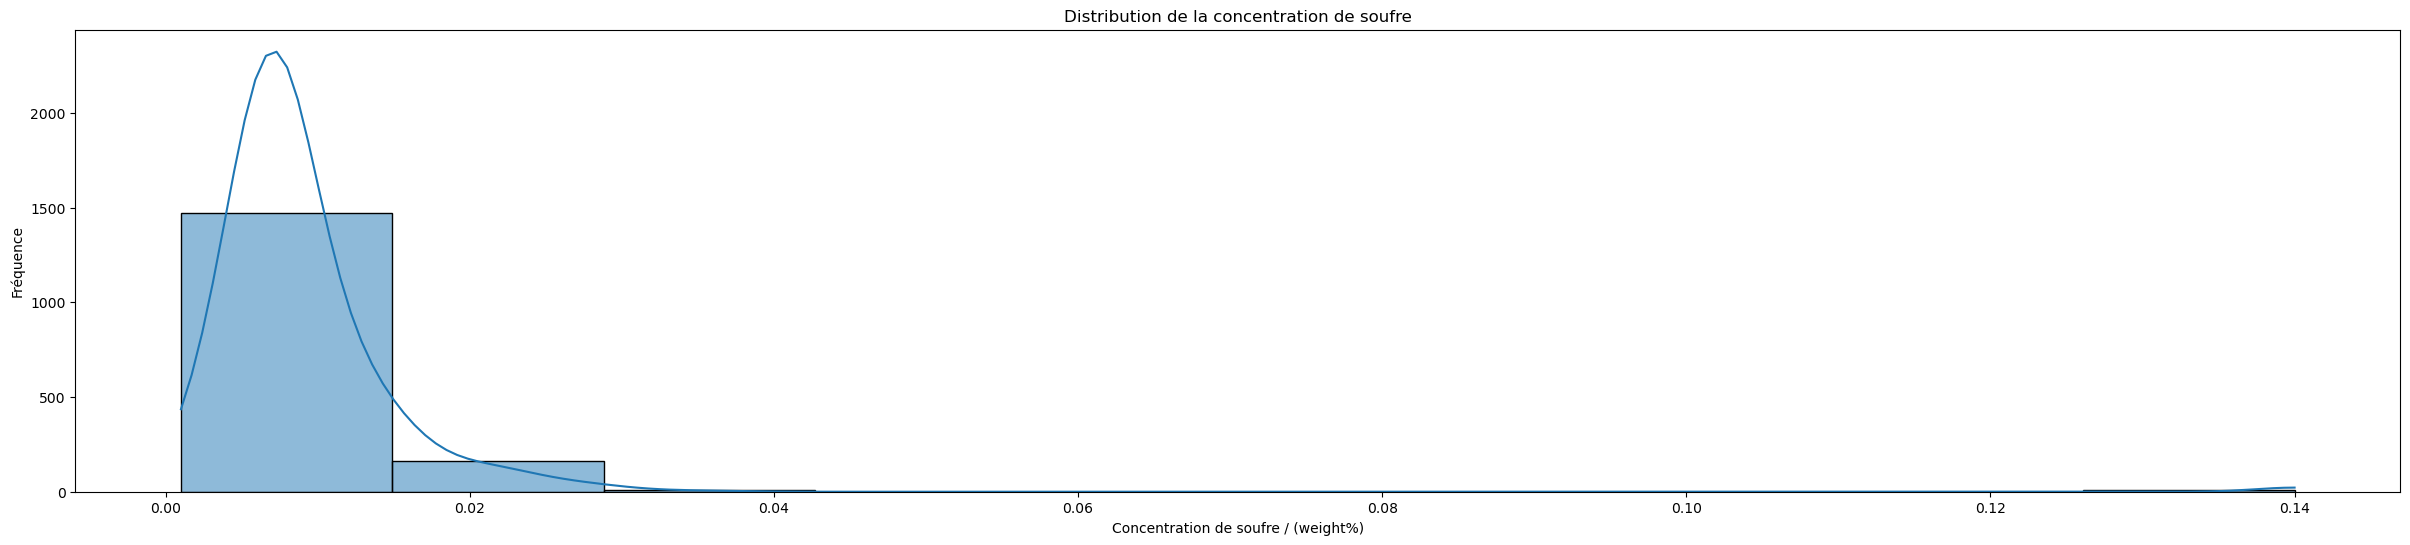

In [913]:
# Tracer le graphique de distribution
plt.figure(figsize=(30, 6))
sns.histplot(data['Sulphur concentration / (weight%)'], bins=10, kde=True)
plt.title('Distribution de la concentration de soufre')
plt.xlabel('Concentration de soufre / (weight%)')
plt.ylabel('Fréquence')
plt.show()

In [915]:
df['Sulphur concentration / (weight%)'].fillna(df['Sulphur concentration / (weight%)'].mean(), inplace=True)

C:\Users\DF6610\AppData\Local\Temp\ipykernel_11764\1020160495.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Sulphur concentration / (weight%)'].fillna(df['Sulphur concentration / (weight%)'].mean(), inplace=True)
C:\Users\DF6610\AppData\Local\Temp\ipykernel_11764\1020160495.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silen

### III.Missing values :  Phosphorus concentration / (weight%) ###

In [918]:
df['Phosphorus concentration / (weight%)'].describe()

count    1642.000000
mean        0.012952
std         0.019627
min         0.002000
25%         0.007000
50%         0.010000
75%         0.014000
max         0.250000
Name: Phosphorus concentration / (weight%), dtype: float64

In [920]:
df[df['Phosphorus concentration / (weight%)'].isnull()]

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Charpy impact toughness / J,Hardness / kg/mm2,50 % FATT,Primary ferrite in microstructure / %,Ferrite with second phase / %,Acicular ferrite / %,Martensite / %,Ferrite with carbide aggregate / %,Weld ID,Common_Prefix
1150,0.11,0.38,1.50,0.029000,NaN,NaN,NaN,0.0,0.005,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gar&K-1975-12mmE-26aw,Gar&K-1975-
1151,0.11,0.37,1.52,0.030000,NaN,NaN,NaN,0.0,0.05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gar&K-1975-12mmE-27aw,Gar&K-1975-
1152,0.11,0.38,1.55,0.029000,NaN,NaN,NaN,0.0,0.09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gar&K-1975-12mmE-28aw,Gar&K-1975-
1153,0.14,0.38,1.65,0.028000,NaN,NaN,NaN,0.5,0.005,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gar&K-1975-12mmE-29aw,Gar&K-1975-
1154,0.10,0.38,1.58,0.028000,NaN,NaN,NaN,0.5,0.06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gar&K-1975-12mmE-30aw,Gar&K-1975-
1155,0.10,0.39,1.68,0.027000,NaN,NaN,NaN,0.5,0.08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gar&K-1975-12mmE-31aw,Gar&K-1975-
1303,0.11,0.18,0.70,0.009529,NaN,0.13,2.28,0.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-hl,Natsume-1990-
1304,0.10,0.17,0.67,0.009529,NaN,0.14,2.31,0.29,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-hh,Natsume-1990-
1305,0.11,0.17,0.65,0.009529,NaN,0.02,2.28,0.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-ll,Natsume-1990-
1306,0.10,0.16,0.61,0.009529,NaN,0.02,2.27,0.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-lh,Natsume-1990-


In [922]:
m = df[df['Common_Prefix'] == 'Gar&K-1975-']['Phosphorus concentration / (weight%)'].mean()

In [924]:
# Fill NaN values with the mean in the original DataFrame
df.loc[df['Common_Prefix'] == 'Gar&K-1975-', 'Phosphorus concentration / (weight%)'] = df.loc[df['Common_Prefix'] == 'Gar&K-1975-', 'Phosphorus concentration / (weight%)'].fillna(m)

In [926]:
df['Phosphorus concentration / (weight%)'].fillna(df['Phosphorus concentration / (weight%)'].mean(), inplace=True)

C:\Users\DF6610\AppData\Local\Temp\ipykernel_11764\3189484787.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Phosphorus concentration / (weight%)'].fillna(df['Phosphorus concentration / (weight%)'].mean(), inplace=True)


### III.Missing values :  other concentrations / (weight%) ###

In [929]:
df['Nickel concentration / (weight%)'].fillna(df['Nickel concentration / (weight%)'].mean(), inplace=True)
df['Chromium concentration / (weight%)'].fillna(df['Chromium concentration / (weight%)'].mean(), inplace=True)
df['Molybdenum concentration / (weight%)'].fillna(df['Molybdenum concentration / (weight%)'].mean(), inplace=True)
df['Vanadium concentration / (weight%)'].fillna(df['Vanadium concentration / (weight%)'].mean(), inplace=True)
df['Copper concentration / (weight%)'].fillna(df['Copper concentration / (weight%)'].mean(), inplace=True)
df['Cobalt concentration / (weight%)'].fillna(df['Cobalt concentration / (weight%)'].mean(), inplace=True)
df['Tungsten concentration / (weight%)'].fillna(df['Tungsten concentration / (weight%)'].mean(), inplace=True)
df['Oxygen concentration / parts per million by weight'].fillna(df['Oxygen concentration / parts per million by weight'].mean(), inplace=True)
df['Titanium concentration / parts per million by weight'].fillna(df['Titanium concentration / parts per million by weight'].mean(), inplace=True)


C:\Users\DF6610\AppData\Local\Temp\ipykernel_11764\1851643774.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Nickel concentration / (weight%)'].fillna(df['Nickel concentration / (weight%)'].mean(), inplace=True)
C:\Users\DF6610\AppData\Local\Temp\ipykernel_11764\1851643774.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

In [931]:
df['Nitrogen concentration / parts per million by weight'].fillna(df['Nitrogen concentration / parts per million by weight'].mean(), inplace=True)
df['Aluminium concentration / parts per million by weight'].fillna(df['Aluminium concentration / parts per million by weight'].mean(), inplace=True)
df['Boron concentration / parts per million by weight'].fillna(df['Boron concentration / parts per million by weight'].mean(), inplace=True)
df['Niobium concentration / parts per million by weight'].fillna(df['Niobium concentration / parts per million by weight'].mean(), inplace=True)
df['Tin concentration / parts per million by weight'].fillna(df['Tin concentration / parts per million by weight'].mean(), inplace=True)
df['Arsenic concentration / parts per million by weight'].fillna(df['Arsenic concentration / parts per million by weight'].mean(), inplace=True)
df['Antimony concentration / parts per million by weight'].fillna(df['Antimony concentration / parts per million by weight'].mean(), inplace=True)

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [933]:
# Convert to numeric, coercing errors to NaN
df['Nitrogen concentration / parts per million by weight'] = pd.to_numeric(df['Nitrogen concentration / parts per million by weight'], errors='coerce')

# Optionally, drop NaN values if you want to calculate the mean only for valid entries
mean_nitrogen_concentration = df['Nitrogen concentration / parts per million by weight'].mean()
print(mean_nitrogen_concentration)

113.37869822485207


In [935]:
df['Nitrogen concentration / parts per million by weight'].fillna(df['Nitrogen concentration / parts per million by weight'].mean(), inplace=True)
df['Aluminium concentration / parts per million by weight'].fillna(df['Aluminium concentration / parts per million by weight'].mean(), inplace=True)
df['Boron concentration / parts per million by weight'].fillna(df['Boron concentration / parts per million by weight'].mean(), inplace=True)
df['Niobium concentration / parts per million by weight'].fillna(df['Niobium concentration / parts per million by weight'].mean(), inplace=True)
df['Tin concentration / parts per million by weight'].fillna(df['Tin concentration / parts per million by weight'].mean(), inplace=True)
df['Arsenic concentration / parts per million by weight'].fillna(df['Arsenic concentration / parts per million by weight'].mean(), inplace=True)
df['Antimony concentration / parts per million by weight'].fillna(df['Antimony concentration / parts per million by weight'].mean(), inplace=True)

C:\Users\DF6610\AppData\Local\Temp\ipykernel_11764\3204121392.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Nitrogen concentration / parts per million by weight'].fillna(df['Nitrogen concentration / parts per million by weight'].mean(), inplace=True)
C:\Users\DF6610\AppData\Local\Temp\ipykernel_11764\3204121392.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never wo

### III.Missing values :  current & Voltage ###

In [938]:
df[df['Current / A'].isnull()]['Common_Prefix'].value_counts()

Common_Prefix
Evans           156
Cunh-1982-       38
EvHtIp1979-      32
Blond&-1984-     18
Sw&Rog-1973       4
Name: count, dtype: int64

In [940]:
evans_c=df[df['Common_Prefix']=='Evans']['Current / A'].mean()
evans_v=df[df['Common_Prefix']=='Evans']['Voltage / V'].mean()

In [942]:
# Fill NaN values with the mean in the original DataFrame
df.loc[df['Common_Prefix'] == 'Evans', 'Current / A'] = df.loc[df['Common_Prefix'] == 'Evans', 'Current / A'].fillna(evans_c)
df.loc[df['Common_Prefix'] == 'Evans', 'Voltage / V'] = df.loc[df['Common_Prefix'] == 'Evans', 'Voltage / V'].fillna(evans_v)

In [944]:
df['Current / A']= df['Current / A'].fillna(df['Current / A'].mean())
df['Voltage / V']= df['Voltage / V'].fillna(df['Voltage / V'].mean())

### III.Missing values :  AC or DC ###

In [947]:
df[df['AC or DC'].isnull()]['Common_Prefix'].value_counts()

Common_Prefix
Evans              156
Birmingham-MAX3      9
RC81033              4
p12-RR82011          2
p28-RR82011          2
p11-RR82011          2
p36-RR82011          2
p35-RR82011          2
p34-RR82011          2
p33-RR82011          2
p32-RR82011          2
p31-RR82011          2
p30-RR82011          2
p29-RR82011          2
p26-RR82011          2
p13-RR82011          2
p10-RR82011          2
p25-RR82011          2
p24-RR82011          2
p23-RR82011          2
p22-RR82011          2
p21-RR82011          2
p16-RR82011          2
p15-RR82011          2
p14-RR82011          2
p9-RR82011           2
Name: count, dtype: int64

In [949]:
df[df['Common_Prefix']=='Evans']['AC or DC'].value_counts()

AC or DC
DC    696
AC      4
Name: count, dtype: int64

In [951]:
df.loc[df['Common_Prefix'] == 'Evans', 'AC or DC'] = df.loc[df['Common_Prefix'] == 'Evans', 'AC or DC'].fillna('DC')

In [953]:
df['AC or DC']= df['AC or DC'].fillna('o')

### III.Missing values :  Electrode positive ou négative ###

In [956]:
df[df['Electrode positive or negative'].isnull()]['Common_Prefix'].value_counts()

Common_Prefix
Evans    156
Name: count, dtype: int64

In [958]:
df[df['Common_Prefix']=='Evans']['Electrode positive or negative'].value_counts()

Electrode positive or negative
+    696
0      4
Name: count, dtype: int64

In [960]:
df['Electrode positive or negative']= df['Electrode positive or negative'].fillna('+')

### III.Missing values :  Post weld heat treatment temperature / deg C et 

Post weld heat treatment time / hours  ###

In [963]:
df[df['Post weld heat treatment time / hours'].isnull()]['Common_Prefix'].value_counts()

Common_Prefix
Gar&K-1975-    13
Name: count, dtype: int64

In [965]:
df[df['Common_Prefix']=='Gar&K-1975-']['Post weld heat treatment temperature / deg C'].mean()

251.1627906976744

In [967]:
gark_t=df[df['Common_Prefix']=='Gar&K-1975-']['Post weld heat treatment temperature / deg C'].mean()
gark_time=df[df['Common_Prefix']=='Gar&K-1975-']['Post weld heat treatment time / hours'].mean()

In [969]:
df['Post weld heat treatment temperature / deg C']= df['Post weld heat treatment temperature / deg C'].fillna(gark_t)
df['Post weld heat treatment time / hours']= df['Post weld heat treatment time / hours'].fillna(gark_time)

### III.Missing values : Charpy   ###

In [972]:
df[df['Charpy impact toughness / J'].isnull()]['Common_Prefix'].value_counts()

Common_Prefix
Evans                      315
Gar&K-1975-                 56
PantK-1990-                 42
Cunh-1982-                  38
Wolst-1974-                 32
KocakP                      21
RaiterGonzal-Mo-1989-       18
PakSven-1990-               17
EvHtIp1979-                 16
Stil-TiB-1978-              16
Pat-1981-                   16
Hunt&-Di-1994-              16
SvenGret-1990-              16
Icici&-1992-                14
Blond&-1984-                12
EPRI-TR-101394s-E9          12
Es-Souni&-Cu/CMn-1990-      12
Ga&K-1975II-                10
Birmingham-MAX3              9
Mart-                        7
Alekseev&-CMnNi-1991-CH      7
Ditt-                        5
Natsume-1990-                4
RC81033                      4
Chandel&-1985W               4
Sw&Rog-1973                  4
p36-RR82011                  2
p35-RR82011                  2
p34-RR82011                  2
p25-RR82011                  2
p32-RR82011                  2
p31-RR82011              

In [974]:
evans_charpyJ=df[df['Common_Prefix']=='Evans']['Charpy impact toughness / J'].mean()
evanc_charpyC=df[df['Common_Prefix']=='Evans']['Charpy temperature / deg C'].mean()

In [976]:
evans_charpyJ

85.73382624768946

In [978]:
df.loc[df['Common_Prefix'] == 'Evans', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'Evans', 'Charpy impact toughness / J'].fillna(evans_charpyJ)
df.loc[df['Common_Prefix'] == 'Evans', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'Evans', 'Charpy temperature / deg C'].fillna(evanc_charpyC)

In [980]:
pant_charpyJ=df[df['Common_Prefix']=='PantK-1990-']['Charpy impact toughness / J'].mean()
pant_charpyC=df[df['Common_Prefix']=='PantK-1990-']['Charpy temperature / deg C'].mean()

In [982]:
df.loc[df['Common_Prefix'] == 'PantK-1990-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'PantK-1990-', 'Charpy impact toughness / J'].fillna(pant_charpyJ)
df.loc[df['Common_Prefix'] == 'PantK-1990-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'PantK-1990-', 'Charpy temperature / deg C'].fillna(pant_charpyC)

In [984]:
sven_charpyJ=df[df['Common_Prefix']=='SvenGret-1990-']['Charpy impact toughness / J'].mean()
sven_charpyC=df[df['Common_Prefix']=='SvenGret-1990-']['Charpy temperature / deg C'].mean()

In [986]:
df.loc[df['Common_Prefix'] == 'SvenGret-1990-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'SvenGret-1990-', 'Charpy impact toughness / J'].fillna(sven_charpyJ)
df.loc[df['Common_Prefix'] == 'SvenGret-1990-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'SvenGret-1990-', 'Charpy temperature / deg C'].fillna(sven_charpyC)

In [988]:
pat_charpyJ=df[df['Common_Prefix']=='Pat-1981-']['Charpy impact toughness / J'].mean()
pat_charpyC=df[df['Common_Prefix']=='Pat-1981-']['Charpy temperature / deg C'].mean()

In [990]:
df.loc[df['Common_Prefix'] == 'Pat-1981-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'Pat-1981-', 'Charpy impact toughness / J'].fillna(pat_charpyJ)
df.loc[df['Common_Prefix'] == 'Pat-1981-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'Pat-1981-', 'Charpy temperature / deg C'].fillna(pat_charpyC)

In [992]:
df[df['Common_Prefix']=='EvHtIp1979-']['Charpy impact toughness / J'].mean()

100.0

In [994]:
evht_charpyJ=df[df['Common_Prefix']=='EvHtIp1979-']['Charpy impact toughness / J'].mean()
evht_charpyC=df[df['Common_Prefix']=='EvHtIp1979-']['Charpy temperature / deg C'].mean()

In [996]:
df.loc[df['Common_Prefix'] == 'EvHtIp1979-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'EvHtIp1979-', 'Charpy impact toughness / J'].fillna(evht_charpyJ)
df.loc[df['Common_Prefix'] == 'EvHtIp1979-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'EvHtIp1979-', 'Charpy temperature / deg C'].fillna(evht_charpyC)

In [998]:
df[df['Common_Prefix']=='Icici&-1992-']['Charpy impact toughness / J'].mean()

51.8125

In [1000]:
ici_charpyJ=df[df['Common_Prefix']=='Icici&-1992-']['Charpy impact toughness / J'].mean()
ici_charpyC=df[df['Common_Prefix']=='Icici&-1992-']['Charpy temperature / deg C'].mean()

In [1002]:
df.loc[df['Common_Prefix'] == 'Icici&-1992-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'Icici&-1992-', 'Charpy impact toughness / J'].fillna(ici_charpyJ)
df.loc[df['Common_Prefix'] == 'Icici&-1992-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'Icici&-1992-', 'Charpy temperature / deg C'].fillna(ici_charpyC)

In [1004]:
df[df['Common_Prefix']=='Blond&-1984-']['Charpy impact toughness / J'].mean()

69.0

In [1006]:
bld_charpyJ=df[df['Common_Prefix']=='Blond&-1984-']['Charpy impact toughness / J'].mean()
bld_charpyC=df[df['Common_Prefix']=='Blond&-1984-']['Charpy temperature / deg C'].mean()

In [1008]:
df.loc[df['Common_Prefix'] == 'Blond&-1984-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'Blond&-1984-', 'Charpy impact toughness / J'].fillna(bld_charpyJ)
df.loc[df['Common_Prefix'] == 'Blond&-1984-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'Blond&-1984-', 'Charpy temperature / deg C'].fillna(bld_charpyC)

In [1010]:
df[df['Common_Prefix']=='Mart-']['Charpy impact toughness / J'].mean()

66.66666666666667

In [1012]:
mrt_charpyJ=df[df['Common_Prefix']=='Mart-']['Charpy impact toughness / J'].mean()
mrt_charpyC=df[df['Common_Prefix']=='Mart-']['Charpy temperature / deg C'].mean()

In [1014]:
df.loc[df['Common_Prefix'] == 'Mart-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'Mart-', 'Charpy impact toughness / J'].fillna(mrt_charpyJ)
df.loc[df['Common_Prefix'] == 'Mart-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'Mart-', 'Charpy temperature / deg C'].fillna(mrt_charpyC)

In [1016]:
df[df['Common_Prefix']=='Ditt-']['Charpy impact toughness / J'].mean()

190.33333333333334

In [1018]:
ditt_charpyJ=df[df['Common_Prefix']=='Ditt-']['Charpy impact toughness / J'].mean()
ditt_charpyC=df[df['Common_Prefix']=='Ditt-']['Charpy temperature / deg C'].mean()

In [1020]:
df.loc[df['Common_Prefix'] == 'Ditt-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'Ditt-', 'Charpy impact toughness / J'].fillna(ditt_charpyJ)
df.loc[df['Common_Prefix'] == 'Ditt-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'Ditt-', 'Charpy temperature / deg C'].fillna(ditt_charpyC)

In [1022]:
df[df['Common_Prefix']=='Chandel&-1985W']['Charpy impact toughness / J'].mean()

115.84210526315789

In [1024]:
chdl_charpyJ=df[df['Common_Prefix']=='Chandel&-1985W']['Charpy impact toughness / J'].mean()
chdl_charpyC=df[df['Common_Prefix']=='Chandel&-1985W']['Charpy temperature / deg C'].mean()

In [1026]:
df.loc[df['Common_Prefix'] == 'Chandel&-1985W', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'Chandel&-1985W', 'Charpy impact toughness / J'].fillna(chdl_charpyJ)
df.loc[df['Common_Prefix'] == 'Chandel&-1985W', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'Chandel&-1985W', 'Charpy temperature / deg C'].fillna(chdl_charpyC)

In [1028]:
df['Charpy impact toughness / J'] = df['Charpy impact toughness / J'].fillna(df['Charpy impact toughness / J'].mean())
df['Charpy temperature / deg C'] = df['Charpy temperature / deg C'].fillna(df['Charpy temperature / deg C'].mean())

### III. Missing Values: features to delete ###

In [1031]:
#50 % FATT                                                1621
#Primary ferrite in microstructure / %                    1554
#Ferrite with second phase / %                            1562
#Acicular ferrite / %                                     1562
#Martensite / %                                           1563
#Ferrite with carbide aggregate / %                       1563

In [1033]:
df = df.drop(columns=['50 % FATT', 'Primary ferrite in microstructure / %', 'Ferrite with second phase / %', 'Acicular ferrite / %','Martensite / %','Ferrite with carbide aggregate / %'])

In [1035]:
df

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Post weld heat treatment time / hours,Yield strength / MPa,Ultimate tensile strength / MPa,Elongation / %,Reduction of Area / %,Charpy temperature / deg C,Charpy impact toughness / J,Hardness / kg/mm2,Weld ID,Common_Prefix
0,0.037,0.30,0.65,0.008,0.012,0.00,2.101273,0.479172,0.097379,0.172163,...,14.0,392.0,466.0,31.9,80.6,-45.136784,85.733826,NaN,Evans-Ni/CMn-1990/1991-0Aaw,Evans
1,0.037,0.30,0.65,0.008,0.012,0.00,2.101273,0.479172,0.097379,0.172163,...,0.0,NaN,NaN,NaN,NaN,-28.000000,100.000000,NaN,Evans-Ni/CMn-1990/1991-0Aawch,Evans
2,0.037,0.30,0.65,0.008,0.012,0.00,2.101273,0.479172,0.097379,0.172163,...,2.0,370.0,456.0,35.2,80.6,-38.000000,100.000000,NaN,Evans-Ni/CMn-1990/1991-0Aht,Evans
3,0.037,0.31,1.03,0.007,0.014,0.00,2.101273,0.479172,0.097379,0.172163,...,14.0,413.0,498.0,31.2,80.6,-45.136784,85.733826,NaN,Evans-Ni/CMn-1990/1991-0Baw,Evans
4,0.037,0.31,1.03,0.007,0.014,0.00,2.101273,0.479172,0.097379,0.172163,...,0.0,NaN,NaN,NaN,NaN,-48.000000,100.000000,NaN,Evans-Ni/CMn-1990/1991-0Bawch,Evans
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.600000,0.980000,0.180000,0.172163,...,2.0,834.0,NaN,NaN,NaN,-35.008558,85.892497,NaN,Birmingham-MAX35,Birmingham-MAX3
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.400000,0.940000,0.190000,0.172163,...,2.0,822.0,NaN,NaN,NaN,-35.008558,85.892497,NaN,Birmingham-MAX36,Birmingham-MAX3
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.200000,0.940000,0.020000,0.172163,...,2.0,660.0,NaN,NaN,NaN,-35.008558,85.892497,NaN,Birmingham-MAX37,Birmingham-MAX3
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.400000,0.970000,0.170000,0.172163,...,2.0,832.0,NaN,NaN,NaN,-35.008558,85.892497,NaN,Birmingham-MAX38,Birmingham-MAX3


### III.Missing values: Résumé ###

In [1038]:
df.isnull().sum()

Carbon concentration / (weight%)                            0
Silicon concentration / (weight%)                           0
Manganese concentration / (weight%)                         0
Sulphur concentration / (weight%)                           0
Phosphorus concentration / (weight%)                        0
Nickel concentration / (weight%)                            0
Chromium concentration / (weight%)                          0
Molybdenum concentration / (weight%)                        0
Vanadium concentration / (weight%)                          0
Copper concentration / (weight%)                            0
Cobalt concentration / (weight%)                            0
Tungsten concentration / (weight%)                          0
Oxygen concentration / parts per million by weight          0
Titanium concentration / parts per million by weight        0
Nitrogen concentration / parts per million by weight        0
Aluminium concentration / parts per million by weight       0
Boron co

# Les variables cibles : 

- **Yield strength** / MPa
- **Ultimate tensile strength** / MPa
- **Elongation** / %
- **Reduction of Area** / %
- **Hardness** / kg/mm²


## IV. Variables Catégoriques ##

### IV. Variables Catégoriques : Introduction

In [1043]:
df.columns

Index(['Carbon concentration / (weight%)', 'Silicon concentration / (weight%)',
       'Manganese concentration / (weight%)',
       'Sulphur concentration / (weight%)',
       'Phosphorus concentration / (weight%)',
       'Nickel concentration / (weight%)',
       'Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Vanadium concentration / (weight%)',
       'Copper concentration / (weight%)', 'Cobalt concentration / (weight%)',
       'Tungsten concentration / (weight%)',
       'Oxygen concentration / parts per million by weight',
       'Titanium concentration / parts per million by weight',
       'Nitrogen concentration / parts per million by weight',
       'Aluminium concentration / parts per million by weight',
       'Boron concentration / parts per million by weight',
       'Niobium concentration / parts per million by weight',
       'Tin concentration / parts per million by weight',
       'Arsenic concentration / parts per millio

In [1045]:
#  'AC or DC'
# 'Electrode positive or negative'
# 'Type of weld'
# Sont des variables catégoriques

### IV. Variables Catégoriques : AC or DC

In [1048]:
df['AC or DC'].value_counts()

AC or DC
DC    1551
o       59
AC      42
Name: count, dtype: int64

In [1050]:
df_encoded_1 = pd.get_dummies(df, columns=['AC or DC'])

In [1052]:
df_encoded_1.columns

Index(['Carbon concentration / (weight%)', 'Silicon concentration / (weight%)',
       'Manganese concentration / (weight%)',
       'Sulphur concentration / (weight%)',
       'Phosphorus concentration / (weight%)',
       'Nickel concentration / (weight%)',
       'Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Vanadium concentration / (weight%)',
       'Copper concentration / (weight%)', 'Cobalt concentration / (weight%)',
       'Tungsten concentration / (weight%)',
       'Oxygen concentration / parts per million by weight',
       'Titanium concentration / parts per million by weight',
       'Nitrogen concentration / parts per million by weight',
       'Aluminium concentration / parts per million by weight',
       'Boron concentration / parts per million by weight',
       'Niobium concentration / parts per million by weight',
       'Tin concentration / parts per million by weight',
       'Arsenic concentration / parts per millio

In [1054]:
df_encoded_1.drop(columns=['AC or DC_o'],inplace=True)

### IV. Variables Catégoriques : 'Electrode positive or negative'

In [1057]:
df['Electrode positive or negative'].value_counts()

Electrode positive or negative
+    1607
0      38
-       7
Name: count, dtype: int64

In [1059]:
df_encoded_2 = pd.get_dummies(df_encoded_1, columns=['Electrode positive or negative'])

In [1061]:
df_encoded_2.columns

Index(['Carbon concentration / (weight%)', 'Silicon concentration / (weight%)',
       'Manganese concentration / (weight%)',
       'Sulphur concentration / (weight%)',
       'Phosphorus concentration / (weight%)',
       'Nickel concentration / (weight%)',
       'Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Vanadium concentration / (weight%)',
       'Copper concentration / (weight%)', 'Cobalt concentration / (weight%)',
       'Tungsten concentration / (weight%)',
       'Oxygen concentration / parts per million by weight',
       'Titanium concentration / parts per million by weight',
       'Nitrogen concentration / parts per million by weight',
       'Aluminium concentration / parts per million by weight',
       'Boron concentration / parts per million by weight',
       'Niobium concentration / parts per million by weight',
       'Tin concentration / parts per million by weight',
       'Arsenic concentration / parts per millio

In [1063]:
df_encoded_2.drop(columns=['Electrode positive or negative_-'],inplace=True)

### IV. Variables Catégoriques : 'Type of Weld'

In [1066]:
df['Type of weld'].value_counts()

Type of weld
MMA      1140
SA        261
FCA        87
TSA        87
ShMA       40
NGSAW      18
NGGMA       7
SAA         4
GTAA        4
GMAA        4
Name: count, dtype: int64

In [1068]:
df_encoded = pd.get_dummies(df_encoded_2, columns=['Type of weld'])

In [1070]:
df_encoded.columns

Index(['Carbon concentration / (weight%)', 'Silicon concentration / (weight%)',
       'Manganese concentration / (weight%)',
       'Sulphur concentration / (weight%)',
       'Phosphorus concentration / (weight%)',
       'Nickel concentration / (weight%)',
       'Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Vanadium concentration / (weight%)',
       'Copper concentration / (weight%)', 'Cobalt concentration / (weight%)',
       'Tungsten concentration / (weight%)',
       'Oxygen concentration / parts per million by weight',
       'Titanium concentration / parts per million by weight',
       'Nitrogen concentration / parts per million by weight',
       'Aluminium concentration / parts per million by weight',
       'Boron concentration / parts per million by weight',
       'Niobium concentration / parts per million by weight',
       'Tin concentration / parts per million by weight',
       'Arsenic concentration / parts per millio

In [1072]:
df_encoded.drop(columns=['Type of weld_GMAA'],inplace=True)

## V. Analyse des composantes principales: ACP

### V. ACP : drop les variables cibles

In [1076]:
df_encoded.columns

Index(['Carbon concentration / (weight%)', 'Silicon concentration / (weight%)',
       'Manganese concentration / (weight%)',
       'Sulphur concentration / (weight%)',
       'Phosphorus concentration / (weight%)',
       'Nickel concentration / (weight%)',
       'Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Vanadium concentration / (weight%)',
       'Copper concentration / (weight%)', 'Cobalt concentration / (weight%)',
       'Tungsten concentration / (weight%)',
       'Oxygen concentration / parts per million by weight',
       'Titanium concentration / parts per million by weight',
       'Nitrogen concentration / parts per million by weight',
       'Aluminium concentration / parts per million by weight',
       'Boron concentration / parts per million by weight',
       'Niobium concentration / parts per million by weight',
       'Tin concentration / parts per million by weight',
       'Arsenic concentration / parts per millio

In [1078]:
X=df_encoded[['Carbon concentration / (weight%)', 'Silicon concentration / (weight%)',
       'Manganese concentration / (weight%)',
       'Sulphur concentration / (weight%)',
       'Phosphorus concentration / (weight%)',
       'Nickel concentration / (weight%)',
       'Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Vanadium concentration / (weight%)',
       'Copper concentration / (weight%)', 'Cobalt concentration / (weight%)',
       'Tungsten concentration / (weight%)',
       'Oxygen concentration / parts per million by weight',
       'Titanium concentration / parts per million by weight',
       'Nitrogen concentration / parts per million by weight',
       'Aluminium concentration / parts per million by weight',
       'Boron concentration / parts per million by weight',
       'Niobium concentration / parts per million by weight',
       'Tin concentration / parts per million by weight',
       'Arsenic concentration / parts per million by weight',
       'Antimony concentration / parts per million by weight', 'Current / A',
       'Voltage / V', 'Heat input / kJ/mm', 'Interpass temperature / deg C',
       'Post weld heat treatment temperature / deg C',
       'Post weld heat treatment time / hours' , 'Charpy temperature / deg C',
       'Charpy impact toughness / J',
        'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']]

In [1080]:
y=df_encoded[['Yield strength / MPa',
       'Ultimate tensile strength / MPa', 'Elongation / %',
       'Reduction of Area / %','Hardness / kg/mm2']]

In [1082]:
X.describe()

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Tin concentration / parts per million by weight,Arsenic concentration / parts per million by weight,Antimony concentration / parts per million by weight,Current / A,Voltage / V,Heat input / kJ/mm,Post weld heat treatment temperature / deg C,Post weld heat treatment time / hours,Charpy temperature / deg C,Charpy impact toughness / J
count,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,...,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000
mean,0.075521,0.328577,1.202821,0.009529,0.012981,0.415034,2.101273,0.479172,0.097379,0.172163,...,42.170986,31.044726,29.456077,272.540723,27.052498,1.700987,304.253097,5.012386,-35.008558,85.892497
std,0.023898,0.112455,0.382137,0.011213,0.019573,0.510950,2.084274,0.330655,0.369331,0.190909,...,37.652480,16.154869,14.568709,180.544551,11.686836,1.298465,284.411103,6.086396,27.075884,38.281865
min,0.029000,0.040000,0.270000,0.001000,0.002000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003000,0.000000,115.000000,11.500000,0.600000,0.000000,0.000000,-114.000000,3.000000
25%,0.061750,0.270000,0.940000,0.006000,0.007000,0.147500,1.037500,0.385000,0.002750,0.140000,...,42.170986,31.044726,29.456077,170.000000,21.000000,1.000000,0.000000,0.000000,-45.136784,80.000000
50%,0.074000,0.320000,1.270000,0.007000,0.010000,0.415034,2.101273,0.479172,0.097379,0.172163,...,42.170986,31.044726,29.456077,170.814286,22.058571,1.000000,250.000000,2.000000,-37.000000,85.892497
75%,0.086000,0.360000,1.440000,0.010000,0.014000,0.415034,2.101273,0.479172,0.097379,0.172163,...,42.170986,31.044726,29.456077,290.000000,29.000000,2.000000,580.000000,10.000000,-30.000000,100.000000
max,0.180000,1.140000,2.250000,0.140000,0.250000,3.500000,10.200000,1.500000,5.000000,1.630000,...,1000.000000,200.000000,200.000000,900.000000,75.360000,7.900000,760.000000,24.000000,188.000000,270.000000


### V. ACP : Centrer et réduire

In [1085]:
def replace_range_with_avg(value):
    if isinstance(value, str) and '-' in value:
        try:
            # Séparer les deux nombres et calculer la moyenne
            numbers = list(map(float, value.split('-')))
            return sum(numbers) / len(numbers)
        except ValueError:
            return value  # Si ce n'est pas un format attendu, garder la valeur originale
    else:
        return value  # Si ce n'est pas une chaîne au format '150-200', garder la valeur originale

# Appliquer la fonction sur toutes les colonnes du DataFrame
X = X.applymap(replace_range_with_avg)


C:\Users\DF6610\AppData\Local\Temp\ipykernel_11764\92468369.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(replace_range_with_avg)


In [1087]:
def center_and_normalize(df):
    # Initialiser le StandardScaler
    scaler = StandardScaler()
    
    # Appliquer le scaler sur le DataFrame (centrement et normalisation)
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    return df_scaled

In [1089]:
X28_scaled = center_and_normalize(X[['Carbon concentration / (weight%)', 'Silicon concentration / (weight%)',
       'Manganese concentration / (weight%)',
       'Sulphur concentration / (weight%)',
       'Phosphorus concentration / (weight%)',
       'Nickel concentration / (weight%)',
       'Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Vanadium concentration / (weight%)',
       'Copper concentration / (weight%)', 'Cobalt concentration / (weight%)',
       'Tungsten concentration / (weight%)',
       'Oxygen concentration / parts per million by weight',
       'Titanium concentration / parts per million by weight',
       'Nitrogen concentration / parts per million by weight',
       'Aluminium concentration / parts per million by weight',
       'Boron concentration / parts per million by weight',
       'Niobium concentration / parts per million by weight',
       'Tin concentration / parts per million by weight',
       'Arsenic concentration / parts per million by weight',
       'Antimony concentration / parts per million by weight', 'Current / A',
       'Voltage / V', 'Heat input / kJ/mm', 'Interpass temperature / deg C',
       'Post weld heat treatment temperature / deg C',
       'Post weld heat treatment time / hours' , 'Charpy temperature / deg C',
       'Charpy impact toughness / J']])

In [1091]:
X28_scaled

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Arsenic concentration / parts per million by weight,Antimony concentration / parts per million by weight,Current / A,Voltage / V,Heat input / kJ/mm,Interpass temperature / deg C,Post weld heat treatment temperature / deg C,Post weld heat treatment time / hours,Charpy temperature / deg C,Charpy impact toughness / J
0,-1.612394,-0.254200,-1.447095,-0.136415,-0.050153,-0.812525,-2.131311e-16,1.343467e-15,7.893242e-16,-2.908609e-16,...,-4.399651e-16,0.0,-0.568124,-0.518047,-0.540021,-0.107148,-0.190814,1.477120,-0.374181,-4.146058e-03
1,-1.612394,-0.254200,-1.447095,-0.136415,-0.050153,-0.812525,-2.131311e-16,1.343467e-15,7.893242e-16,-2.908609e-16,...,-4.399651e-16,0.0,-0.568124,-0.518047,-0.540021,-0.107148,-1.070089,-0.823789,0.258927,3.686282e-01
2,-1.612394,-0.254200,-1.447095,-0.136415,-0.050153,-0.812525,-2.131311e-16,1.343467e-15,7.893242e-16,-2.908609e-16,...,-4.399651e-16,0.0,-0.568124,-0.518047,-0.540021,-0.107148,0.969830,-0.495087,-0.110517,3.686282e-01
3,-1.612394,-0.165249,-0.452386,-0.225627,0.052059,-0.812525,-2.131311e-16,1.343467e-15,7.893242e-16,-2.908609e-16,...,-4.399651e-16,0.0,-0.568124,-0.518047,-0.540021,-0.107148,-0.190814,1.477120,-0.374181,-4.146058e-03
4,-1.612394,-0.165249,-0.452386,-0.225627,0.052059,-0.812525,-2.131311e-16,1.343467e-15,7.893242e-16,-2.908609e-16,...,-4.399651e-16,0.0,-0.568124,-0.518047,-0.540021,-0.107148,-1.070089,-0.823789,-0.479961,3.686282e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,1.024597,0.190556,-0.792681,-0.136415,0.154270,0.362113,3.118925e+00,1.515115e+00,2.237726e-01,-2.908609e-16,...,-4.399651e-16,0.0,0.983209,0.252283,0.230352,-0.107148,1.602908,-0.495087,0.000000,-3.713288e-16
1648,0.522313,0.279507,-0.845034,-0.136415,0.205376,0.303381,3.022939e+00,1.394107e+00,2.508568e-01,-2.908609e-16,...,-4.399651e-16,0.0,0.983209,0.252283,0.230352,-0.107148,1.602908,-0.495087,0.000000,-3.713288e-16
1649,0.606027,0.101605,-0.818857,-0.136415,0.154270,-0.479711,2.926953e+00,1.394107e+00,-2.095744e-01,-2.908609e-16,...,-4.399651e-16,0.0,0.983209,0.252283,0.230352,-0.107148,1.602908,-0.495087,0.000000,-3.713288e-16
1650,0.689741,0.190556,-0.792681,-0.136415,0.154270,0.244649,3.022939e+00,1.484863e+00,1.966884e-01,-2.908609e-16,...,-4.399651e-16,0.0,0.983209,0.252283,0.230352,-0.107148,1.602908,-0.495087,0.000000,-3.713288e-16


### V. ACP : Choix du nombre de composants

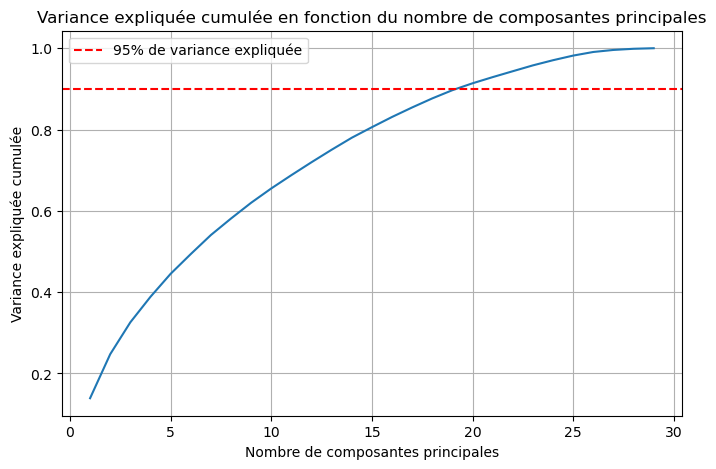

In [1094]:
# Appliquer la PCA
pca = PCA()  # Laisser scikit-learn décider du nombre maximal de composantes
pca.fit(X28_scaled)

# Variance expliquée par chaque composante
explained_variance_ratio = pca.explained_variance_ratio_

# Calcul de la variance cumulée
explained_variance_cumulative = np.cumsum(explained_variance_ratio)

# Tracer le graphe
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_cumulative) + 1), explained_variance_cumulative, marker='', linestyle='-')
plt.title('Variance expliquée cumulée en fonction du nombre de composantes principales')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
# Ajouter une ligne horizontale pour montrer le seuil de 95% de variance expliquée
plt.axhline(y=0.9, color='r', linestyle='--', label='95% de variance expliquée')

# Ajouter des titres et des labels
plt.title('Variance expliquée cumulée en fonction du nombre de composantes principales')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')

# Afficher la grille et la légende
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [1096]:
# si on prend 20 composantes on aura 90% de la variance

### V. ACP

In [1099]:
# Appliquer la PCA
pca = PCA(n_components=20) 
pca.fit(X28_scaled)
pca_result = pca.transform(X28_scaled)
# Créer un DataFrame pour les résultats de la PCA
pca_X = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 
  'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18','PC19','PC20'])
# Afficher les résultats
pca_X

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,0.797559,-1.243604,-0.877140,-0.262090,0.049972,-0.101886,0.187807,-0.931963,0.419365,0.621394,0.509015,0.380826,0.333745,0.101285,0.363268,-0.392848,0.088598,-1.466268,0.205486,0.337017
1,0.191637,-0.946577,-0.121267,0.400053,-0.032788,0.490045,0.708667,-0.569250,0.560366,0.113864,0.138211,0.201124,0.268386,-0.559635,-0.637160,-1.482710,0.587462,-1.244049,0.640521,0.303317
2,0.896423,-0.926910,-0.410839,0.074153,-0.078237,0.399860,0.163795,-0.927108,0.544266,0.112373,0.402958,0.303539,0.176133,-0.083308,-0.619629,-0.987714,0.537169,-0.638320,0.648522,-0.055854
3,0.612019,-1.248647,-0.749723,-0.004150,0.162214,-0.124930,0.151968,-0.563293,0.345061,0.748242,0.291948,0.057517,0.244182,-0.190327,0.649637,0.002578,0.041214,-1.044926,0.283594,0.249038
4,-0.105725,-1.119186,-0.055004,0.583392,0.193385,0.119365,0.516923,-0.068460,0.494983,0.147713,0.028800,-0.008664,0.179886,-0.794430,-0.351143,-1.153179,0.686908,-0.790560,0.832369,0.167688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,3.038229,1.795574,1.509149,-0.212588,-0.042027,-0.115225,-0.869771,0.539871,-0.294937,-1.029650,0.344167,0.305348,-0.295061,0.563932,-0.772949,-0.604753,-0.901064,0.339436,0.073573,-0.512355
1648,4.808031,2.670633,3.264781,0.359646,0.028428,-0.362408,-0.098992,0.425616,-0.598172,-1.369174,0.442300,0.208994,-0.010876,-0.644396,-0.390194,-0.731076,-1.944285,-0.776175,-0.692140,-0.325335
1649,1.652439,1.172069,0.669415,-0.227183,-0.617368,0.067445,-0.859174,-0.242586,-0.155671,-0.539170,0.534169,-0.043788,-0.302953,0.823043,-0.485357,-0.808112,-0.232425,0.558158,0.629427,0.049737
1650,2.611957,1.566247,1.652512,0.018777,-0.531194,-0.098718,-0.414819,-0.023989,-0.681137,-0.744184,0.408692,0.295778,-0.133645,0.420452,-0.557028,-0.663613,-0.940846,0.295216,0.001250,0.086947


In [1101]:
print("Variance expliquée cumulée par chaque composante :", pca.explained_variance_ratio_.sum())

Variance expliquée cumulée par chaque composante : 0.9137576997162394


In [1103]:
X_processed=pd.concat([pca_X,X[['AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']]],axis=1)

In [1105]:
data_processed=pd.concat([X_processed,y],axis=1)
data_processed

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,Type of weld_NGSAW,Type of weld_SA,Type of weld_SAA,Type of weld_ShMA,Type of weld_TSA,Yield strength / MPa,Ultimate tensile strength / MPa,Elongation / %,Reduction of Area / %,Hardness / kg/mm2
0,0.797559,-1.243604,-0.877140,-0.262090,0.049972,-0.101886,0.187807,-0.931963,0.419365,0.621394,...,False,False,False,False,False,392.0,466.0,31.9,80.6,NaN
1,0.191637,-0.946577,-0.121267,0.400053,-0.032788,0.490045,0.708667,-0.569250,0.560366,0.113864,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN
2,0.896423,-0.926910,-0.410839,0.074153,-0.078237,0.399860,0.163795,-0.927108,0.544266,0.112373,...,False,False,False,False,False,370.0,456.0,35.2,80.6,NaN
3,0.612019,-1.248647,-0.749723,-0.004150,0.162214,-0.124930,0.151968,-0.563293,0.345061,0.748242,...,False,False,False,False,False,413.0,498.0,31.2,80.6,NaN
4,-0.105725,-1.119186,-0.055004,0.583392,0.193385,0.119365,0.516923,-0.068460,0.494983,0.147713,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,3.038229,1.795574,1.509149,-0.212588,-0.042027,-0.115225,-0.869771,0.539871,-0.294937,-1.029650,...,False,True,False,False,False,834.0,NaN,NaN,NaN,NaN
1648,4.808031,2.670633,3.264781,0.359646,0.028428,-0.362408,-0.098992,0.425616,-0.598172,-1.369174,...,False,True,False,False,False,822.0,NaN,NaN,NaN,NaN
1649,1.652439,1.172069,0.669415,-0.227183,-0.617368,0.067445,-0.859174,-0.242586,-0.155671,-0.539170,...,False,True,False,False,False,660.0,NaN,NaN,NaN,NaN
1650,2.611957,1.566247,1.652512,0.018777,-0.531194,-0.098718,-0.414819,-0.023989,-0.681137,-0.744184,...,False,True,False,False,False,832.0,NaN,NaN,NaN,NaN


### V. ACP : interprétation

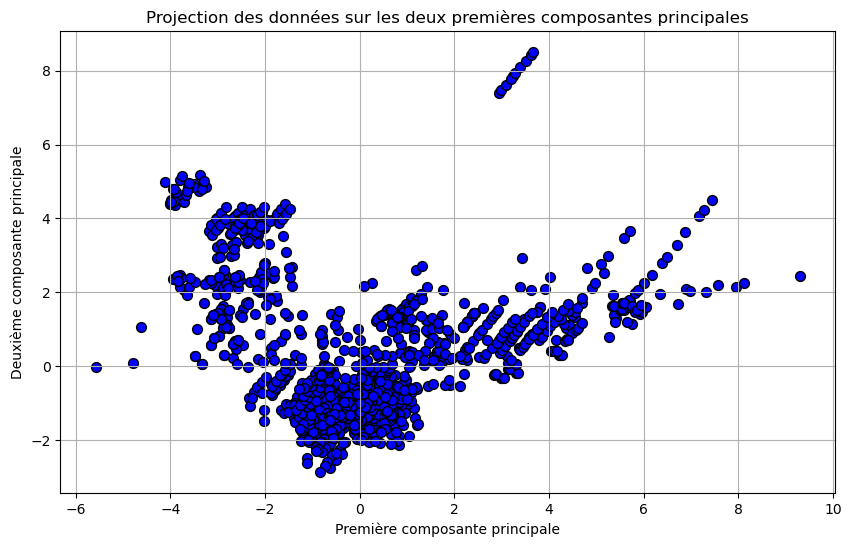

In [1108]:
#Projection des données sur les deux premières composantes principales
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', edgecolor='k', s=50)
plt.title('Projection des données sur les deux premières composantes principales')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.grid(True)
plt.show()

In [1110]:
# Contribution des variables aux composantes principales
# Créer un DataFrame pour visualiser les coefficients
components_df = pd.DataFrame(pca.components_, columns=X28_scaled.columns, index=[f'Composante {i+1}' for i in range(pca.n_components_)])

# Afficher les poids des variables pour les deux premières composantes
print("Poids des variables pour les deux premières composantes principales :")
components_df

Poids des variables pour les deux premières composantes principales :


,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Arsenic concentration / parts per million by weight,Antimony concentration / parts per million by weight,Current / A,Voltage / V,Heat input / kJ/mm,Interpass temperature / deg C,Post weld heat treatment temperature / deg C,Post weld heat treatment time / hours,Charpy temperature / deg C,Charpy impact toughness / J
Composante 1,-0.046470,-0.144884,-0.176327,-0.003606,0.023677,0.005283,0.378064,0.389865,0.057704,-0.052946,...,-0.111219,-0.171065,-0.211125,-0.109014,-0.209414,-0.191422,0.345840,0.167966,0.151338,-0.029973
Composante 2,0.230007,-0.116466,0.003964,0.304383,0.279111,-0.133038,0.094237,0.040550,-0.027244,-0.014952,...,-0.031798,-0.053969,0.441162,0.408408,0.435933,0.096126,0.066408,-0.097401,0.226781,-0.032919
Composante 3,0.195987,0.109413,0.118377,-0.322562,-0.282189,0.010845,0.276485,-0.000074,0.015835,-0.035603,...,0.321109,0.372170,-0.017596,-0.010311,-0.000941,0.025845,-0.082320,-0.277057,0.082764,-0.017145
Composante 4,-0.232600,0.471247,0.210862,0.192397,0.229320,0.034261,0.062994,0.100084,-0.066111,-0.058255,...,-0.173531,-0.122835,-0.119530,-0.119852,-0.118732,-0.017193,-0.106018,-0.220051,0.100964,-0.003525
Composante 5,-0.060168,-0.052267,0.106460,0.436123,0.488221,0.082022,-0.010285,-0.112408,0.068229,0.003042,...,0.262781,0.269755,-0.186755,-0.071371,-0.106422,-0.254865,-0.044656,-0.034437,-0.154192,-0.278030
Composante 6,0.076177,0.004140,-0.025760,0.171183,0.171044,-0.101661,-0.044072,0.056341,0.007898,-0.183611,...,-0.034552,0.184084,-0.080524,-0.177625,-0.137547,0.208343,0.048397,-0.045917,0.470486,0.619585
Composante 7,-0.378103,-0.253664,-0.013916,-0.014284,-0.006921,0.416925,-0.017179,-0.088336,-0.222735,0.462481,...,-0.080735,-0.006329,-0.011806,0.135761,0.041379,-0.202217,-0.221469,-0.046062,0.211000,0.232198
Composante 8,0.188283,-0.115886,0.381350,0.040477,0.031863,0.085782,0.104498,0.024501,0.247533,-0.016356,...,-0.337797,-0.074465,-0.066076,-0.006659,-0.086008,0.274296,-0.187123,-0.128389,-0.178810,0.042852
Composante 9,-0.091380,0.100687,-0.081208,0.002547,-0.022060,-0.279282,-0.056444,-0.053655,-0.304463,0.122312,...,0.027327,0.091394,-0.028928,0.051853,-0.020062,0.105979,-0.005571,-0.027979,-0.012073,0.212914
Composante 10,-0.091098,-0.078817,0.133395,-0.036954,-0.020810,-0.344294,-0.146817,0.057335,0.658481,0.190706,...,0.118489,-0.018338,0.033308,-0.014519,0.050482,-0.229843,-0.023621,0.283521,0.125863,0.119025


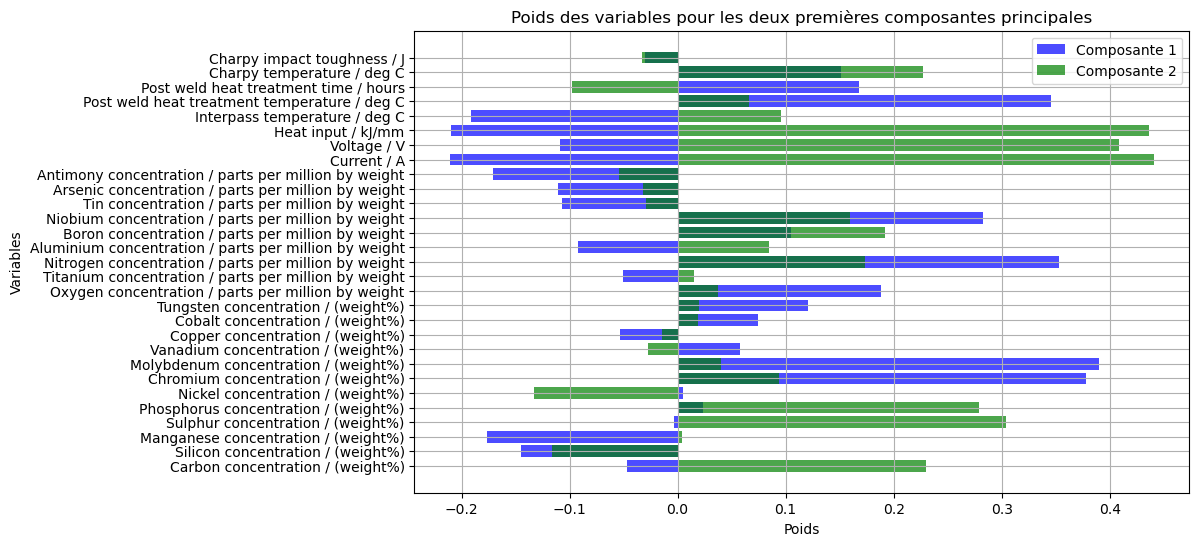

In [1112]:
# Visualiser les poids des variables pour les deux premières composantes
plt.figure(figsize=(10, 6))
plt.barh(components_df.columns, components_df.iloc[0], color='b', alpha=0.7, label='Composante 1')
plt.barh(components_df.columns, components_df.iloc[1], color='g', alpha=0.7, label='Composante 2')
plt.title('Poids des variables pour les deux premières composantes principales')
plt.xlabel('Poids')
plt.ylabel('Variables')
plt.legend()
plt.grid(True)
plt.show()

## VI. Clustering

In [1115]:
scaled_features=X_processed

In [1117]:
k= 6  
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_features)

# Ajouter les labels de cluster à vos données
X_processed['Cluster'] = kmeans.labels_

C:\Users\DF6610\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


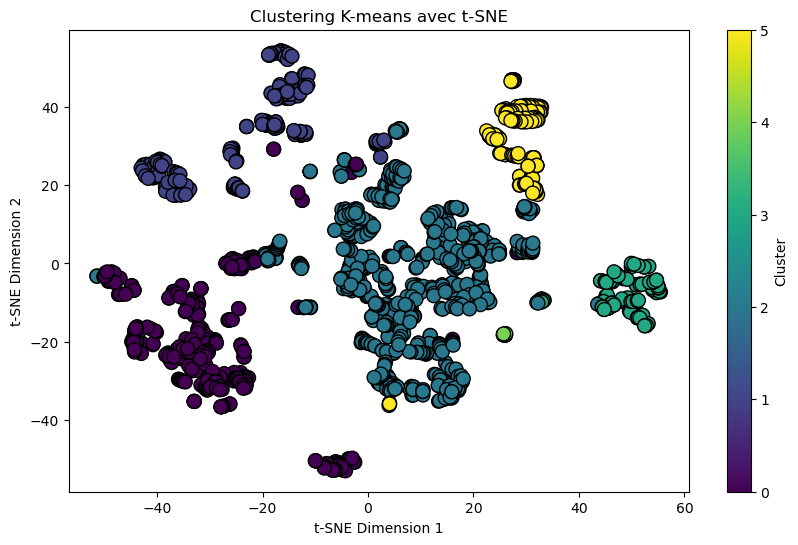

In [1119]:
# Appliquer t-SNE pour réduire les dimensions à 2
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(scaled_features)

# Créer un DataFrame avec les résultats t-SNE et les clusters
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = kmeans.labels_

# Visualisation
plt.figure(figsize=(10, 6))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=100)
plt.title('Clustering K-means avec t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

In [1120]:
data_processed['clusters']=kmeans.labels_

In [1121]:
def extract_numeric(value):
    if isinstance(value, str):  # Vérifie si la valeur est une chaîne
        return pd.to_numeric(value.split('(')[0], errors='coerce')
    else:
        return np.nan  # Retourne NaN si ce n'est pas une chaîne

In [1125]:
data_processed['Hardness / kg/mm2'] = data_processed['Hardness / kg/mm2'].apply(extract_numeric)

In [1127]:
df_pivot= pd.pivot_table(data_processed,values=['Yield strength / MPa', 'Ultimate tensile strength / MPa',
       'Elongation / %', 'Reduction of Area / %', 'Hardness / kg/mm2'],index=['clusters'],aggfunc='mean')
df_pivot

,Elongation / %,Hardness / kg/mm2,Reduction of Area / %,Ultimate tensile strength / MPa,Yield strength / MPa
clusters,,,,,
0,27.355217,187.500000,76.288696,572.270281,493.106867
1,26.164667,196.428571,63.759036,606.310345,510.505376
2,27.217551,213.228571,75.671429,580.410980,494.851838
3,19.480556,NaN,63.805556,741.416667,636.395349
4,22.000000,NaN,73.933333,654.000000,602.000000
5,20.583333,223.111111,61.246875,631.780000,536.186047


In [1129]:
data_processed[['Yield strength / MPa', 'Ultimate tensile strength / MPa','Elongation / %', 'Reduction of Area / %', 'Hardness / kg/mm2']].describe()

,Yield strength / MPa,Ultimate tensile strength / MPa,Elongation / %,Reduction of Area / %,Hardness / kg/mm2
count,780.000000,738.000000,700.000000,705.000000,96.000000
mean,508.557179,594.386314,26.275714,71.799858,206.812500
std,92.865446,88.636238,4.895986,8.926551,30.929227
min,315.000000,447.000000,10.600000,17.000000,143.000000
25%,443.000000,532.775000,22.800000,68.000000,182.750000
50%,495.000000,575.500000,26.800000,75.000000,214.500000
75%,559.250000,647.000000,30.000000,78.000000,230.000000
max,920.000000,1151.000000,37.000000,83.000000,265.000000


## VII. Regressions

In [1132]:
y.isnull().sum()

Yield strength / MPa                872
Ultimate tensile strength / MPa     914
Elongation / %                      952
Reduction of Area / %               947
Hardness / kg/mm2                  1514
dtype: int64

### VII. Yield strength

In [1135]:
data_processed.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA',
       'Yield strength / MPa', 'Ultimate tensile strength / MPa',
       'Elongation / %', 'Reduction of Area / %', 'Hardness / kg/mm2',
       'clusters'],
      dtype='object')

In [1137]:
yield_data=data_processed[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA',
       'Yield strength / MPa']]

In [1139]:
yield_data_test=yield_data[yield_data['Yield strength / MPa'].isnull()]
yield_data_test

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,Type of weld_FCA,Type of weld_GTAA,Type of weld_MMA,Type of weld_NGGMA,Type of weld_NGSAW,Type of weld_SA,Type of weld_SAA,Type of weld_ShMA,Type of weld_TSA,Yield strength / MPa
1,0.191637,-0.946577,-0.121267,0.400053,-0.032788,0.490045,0.708667,-0.569250,0.560366,0.113864,...,False,False,True,False,False,False,False,False,False,NaN
4,-0.105725,-1.119186,-0.055004,0.583392,0.193385,0.119365,0.516923,-0.068460,0.494983,0.147713,...,False,False,True,False,False,False,False,False,False,NaN
7,-0.383471,-1.130974,0.150010,0.885047,0.297111,0.029276,0.262337,0.377801,0.421233,0.209400,...,False,False,True,False,False,False,False,False,False,NaN
10,-0.467211,-0.942067,0.285916,1.102690,0.385389,0.281618,0.392561,0.729727,0.301269,0.433887,...,False,False,True,False,False,False,False,False,False,NaN
15,-0.101108,-1.262912,0.088667,0.609782,0.220693,-0.186012,0.747267,-0.038613,0.156444,-0.243391,...,False,False,True,False,False,False,False,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,-1.069155,-1.469450,-1.393595,-1.861504,0.335930,-0.499417,1.957167,0.031782,0.965693,1.296542,...,False,False,True,False,False,False,False,False,False,NaN
1639,-1.219635,-1.717515,-1.474473,-1.992886,1.069774,-2.308203,1.231895,0.195585,0.581630,0.900566,...,False,False,True,False,False,False,False,False,False,NaN
1641,-1.033400,-1.327159,-1.543491,-1.813324,0.142618,-0.455387,3.596232,-0.423468,1.365672,2.015753,...,False,False,True,False,False,False,False,False,False,NaN
1642,-1.267747,-1.700898,-1.670234,-2.000656,0.961910,-2.524901,2.754031,-0.160575,0.988300,1.550028,...,False,False,True,False,False,False,False,False,False,NaN


In [1141]:
yield_data_model = yield_data[yield_data['Yield strength / MPa'].notnull()]
yield_data_model.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA',
       'Yield strength / MPa'],
      dtype='object')

In [1143]:
x=yield_data_model[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']]
y=yield_data_model['Yield strength / MPa']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [1145]:
model =  SGDRegressor()
model.fit(X_train, y_train)

SGDRegressor()

In [1147]:
# Prédire les valeurs sur l'ensemble de test
y_pred = model.predict(X_test)
# Évaluer les performances du modèle
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE : {rmse:.2f}')

RMSE : 75.75


In [1149]:
# Afficher les hyperparamètres du modèle
hyperparameters = model.get_params()
print("Hyperparamètres du modèle :")
for param, value in hyperparameters.items():
    print(f"{param}: {value}")

Hyperparamètres du modèle :
alpha: 0.0001
average: False
early_stopping: False
epsilon: 0.1
eta0: 0.01
fit_intercept: True
l1_ratio: 0.15
learning_rate: invscaling
loss: squared_error
max_iter: 1000
n_iter_no_change: 5
penalty: l2
power_t: 0.25
random_state: None
shuffle: True
tol: 0.001
validation_fraction: 0.1
verbose: 0
warm_start: False


In [1151]:
yield_data_test.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA',
       'Yield strength / MPa'],
      dtype='object')

In [1153]:
new_data=yield_data_test[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']]
pred=model.predict(new_data)

In [1155]:
# Trouver les indices des valeurs manquantes
nan_indices = data_processed[data_processed['Yield strength / MPa'].isnull()].index

# Remplacer les valeurs manquantes avec les valeurs de 'pred'
data_processed.loc[nan_indices, 'Yield strength / MPa'] = pred

### VII. Ultimate tensile strength / MPa

In [1158]:
yield_data=data_processed[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA',
       'Ultimate tensile strength / MPa']]

In [1160]:
yield_data_test=yield_data[yield_data['Ultimate tensile strength / MPa'].isnull()]

In [1162]:
yield_data_model = yield_data[yield_data['Ultimate tensile strength / MPa'].notnull()]

In [1164]:
x=yield_data_model[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']]
y=yield_data_model['Ultimate tensile strength / MPa']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [1166]:
model =  SGDRegressor()
model.fit(X_train, y_train)

SGDRegressor()

In [1168]:
# Prédire les valeurs sur l'ensemble de test
y_pred = model.predict(X_test)
# Évaluer les performances du modèle
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE : {rmse:.2f}')

RMSE : 74.42


In [1170]:
new_data=yield_data_test[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']]
pred=model.predict(new_data)

In [1172]:
# Trouver les indices des valeurs manquantes
nan_indices = data_processed[data_processed['Ultimate tensile strength / MPa'].isnull()].index

# Remplacer les valeurs manquantes avec les valeurs de 'pred'
data_processed.loc[nan_indices, 'Ultimate tensile strength / MPa'] = pred

### VII. Elongation / %

In [1175]:
yield_data=data_processed[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA',
       'Elongation / %']]
yield_data_test=yield_data[yield_data['Elongation / %'].isnull()]
yield_data_model = yield_data[yield_data['Elongation / %'].notnull()]
x=yield_data_model[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']]
y=yield_data_model['Elongation / %']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model =  SGDRegressor()
model.fit(X_train, y_train)
# Prédire les valeurs sur l'ensemble de test
y_pred = model.predict(X_test)
# Évaluer les performances du modèle
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE : {rmse:.2f}')
new_data=yield_data_test[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']]
pred=model.predict(new_data)
# Trouver les indices des valeurs manquantes
nan_indices = data_processed[data_processed['Elongation / %'].isnull()].index

# Remplacer les valeurs manquantes avec les valeurs de 'pred'
data_processed.loc[nan_indices, 'Elongation / %'] = pred

RMSE : 4.28


### VII. Reduction of area / %

In [1178]:
yield_data=data_processed[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA',
       'Reduction of Area / %']]
yield_data_test=yield_data[yield_data['Reduction of Area / %'].isnull()]
yield_data_model = yield_data[yield_data['Reduction of Area / %'].notnull()]
x=yield_data_model[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']]
y=yield_data_model['Reduction of Area / %']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model =  SGDRegressor()
model.fit(X_train, y_train)
# Prédire les valeurs sur l'ensemble de test
y_pred = model.predict(X_test)
# Évaluer les performances du modèle
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE : {rmse:.2f}')
new_data=yield_data_test[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']]
pred=model.predict(new_data)
# Trouver les indices des valeurs manquantes
nan_indices = data_processed[data_processed['Reduction of Area / %'].isnull()].index

# Remplacer les valeurs manquantes avec les valeurs de 'pred'
data_processed.loc[nan_indices, 'Reduction of Area / %'] = pred

RMSE : 6.45


### VII. Hardness / kg/mm2

In [1181]:
yield_data=data_processed[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA',
       'Hardness / kg/mm2']]
yield_data_test=yield_data[yield_data['Hardness / kg/mm2'].isnull()]
yield_data_model = yield_data[yield_data['Hardness / kg/mm2'].notnull()]
x=yield_data_model[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']]
y=yield_data_model['Hardness / kg/mm2']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model =  SGDRegressor()
model.fit(X_train, y_train)
# Prédire les valeurs sur l'ensemble de test
y_pred = model.predict(X_test)
# Évaluer les performances du modèle
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE : {rmse:.2f}')
new_data=yield_data_test[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']]
pred=model.predict(new_data)
# Trouver les indices des valeurs manquantes
nan_indices = data_processed[data_processed['Hardness / kg/mm2'].isnull()].index

# Remplacer les valeurs manquantes avec les valeurs de 'pred'
data_processed.loc[nan_indices, 'Hardness / kg/mm2'] = pred

RMSE : 13.75


In [1183]:
data_processed.isnull().any()

PC1                                 False
PC2                                 False
PC3                                 False
PC4                                 False
PC5                                 False
PC6                                 False
PC7                                 False
PC8                                 False
PC9                                 False
PC10                                False
PC11                                False
PC12                                False
PC13                                False
PC14                                False
PC15                                False
PC16                                False
PC17                                False
PC18                                False
PC19                                False
PC20                                False
AC or DC_AC                         False
AC or DC_DC                         False
Electrode positive or negative_+    False
Electrode positive or negative_0  

## VII. Clustering quality

In [1212]:
k= 6
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(data_processed[['Yield strength / MPa', 'Ultimate tensile strength / MPa','Elongation / %','Reduction of Area / %','Hardness / kg/mm2']])

# Ajouter les labels de cluster à vos données
data_processed['cluster_quality'] = kmeans.labels_

C:\Users\DF6610\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


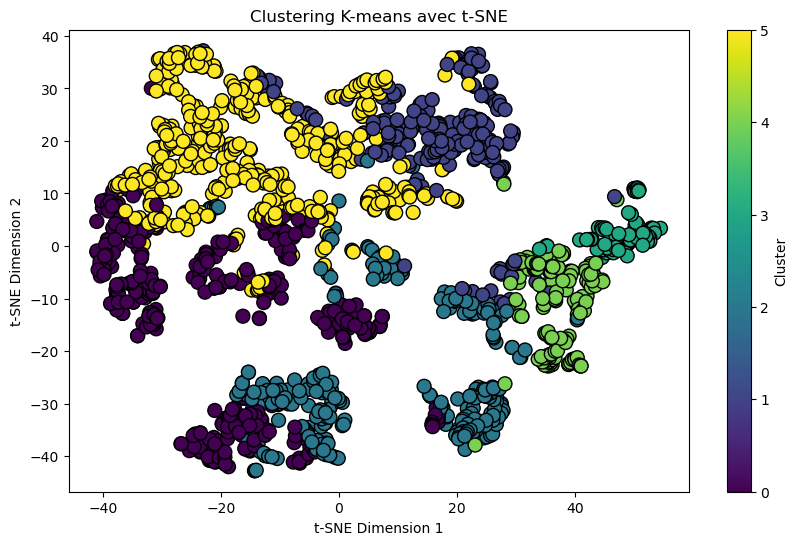

In [1214]:
# Appliquer t-SNE pour réduire les dimensions à 2
quality_scaled = center_and_normalize(data_processed[['Yield strength / MPa', 'Ultimate tensile strength / MPa','Elongation / %','Reduction of Area / %','Hardness / kg/mm2']])
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(quality_scaled)

# Créer un DataFrame avec les résultats t-SNE et les clusters
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = kmeans.labels_

# Visualisation
plt.figure(figsize=(10, 6))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=100)
plt.title('Clustering K-means avec t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

In [1216]:
df_pivot= pd.pivot_table(data_processed,values=['Yield strength / MPa', 'Ultimate tensile strength / MPa',
       'Elongation / %', 'Reduction of Area / %', 'Hardness / kg/mm2'],index=['cluster_quality'],aggfunc='mean')
df_pivot

,Elongation / %,Hardness / kg/mm2,Reduction of Area / %,Ultimate tensile strength / MPa,Yield strength / MPa
cluster_quality,,,,,
0,29.571865,167.973233,75.771844,507.505820,414.585367
1,24.638007,226.847063,66.690867,663.593203,574.514660
2,25.856795,131.325589,70.029545,584.572399,497.735863
3,15.671140,141.288021,51.790843,860.865381,768.849386
4,21.412059,111.387921,69.019095,719.482661,615.720267
5,28.047431,221.619043,75.983828,573.099644,484.435438


In [1218]:
data_processed[['Yield strength / MPa', 'Ultimate tensile strength / MPa','Elongation / %','Reduction of Area / %','Hardness / kg/mm2']].describe()

,Yield strength / MPa,Ultimate tensile strength / MPa,Elongation / %,Reduction of Area / %,Hardness / kg/mm2
count,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000
mean,508.576593,599.414386,26.331446,71.708776,179.342259
std,90.198082,91.351330,4.879650,10.784799,54.149621
min,315.000000,426.408477,6.803732,-20.678736,-78.183257
25%,453.000000,538.025886,23.359137,66.978741,141.155675
50%,491.506834,579.165753,27.018497,75.000000,187.500450
75%,544.039571,636.344099,30.050459,78.800000,217.846954
max,920.000000,1151.000000,37.000000,84.297239,307.275824


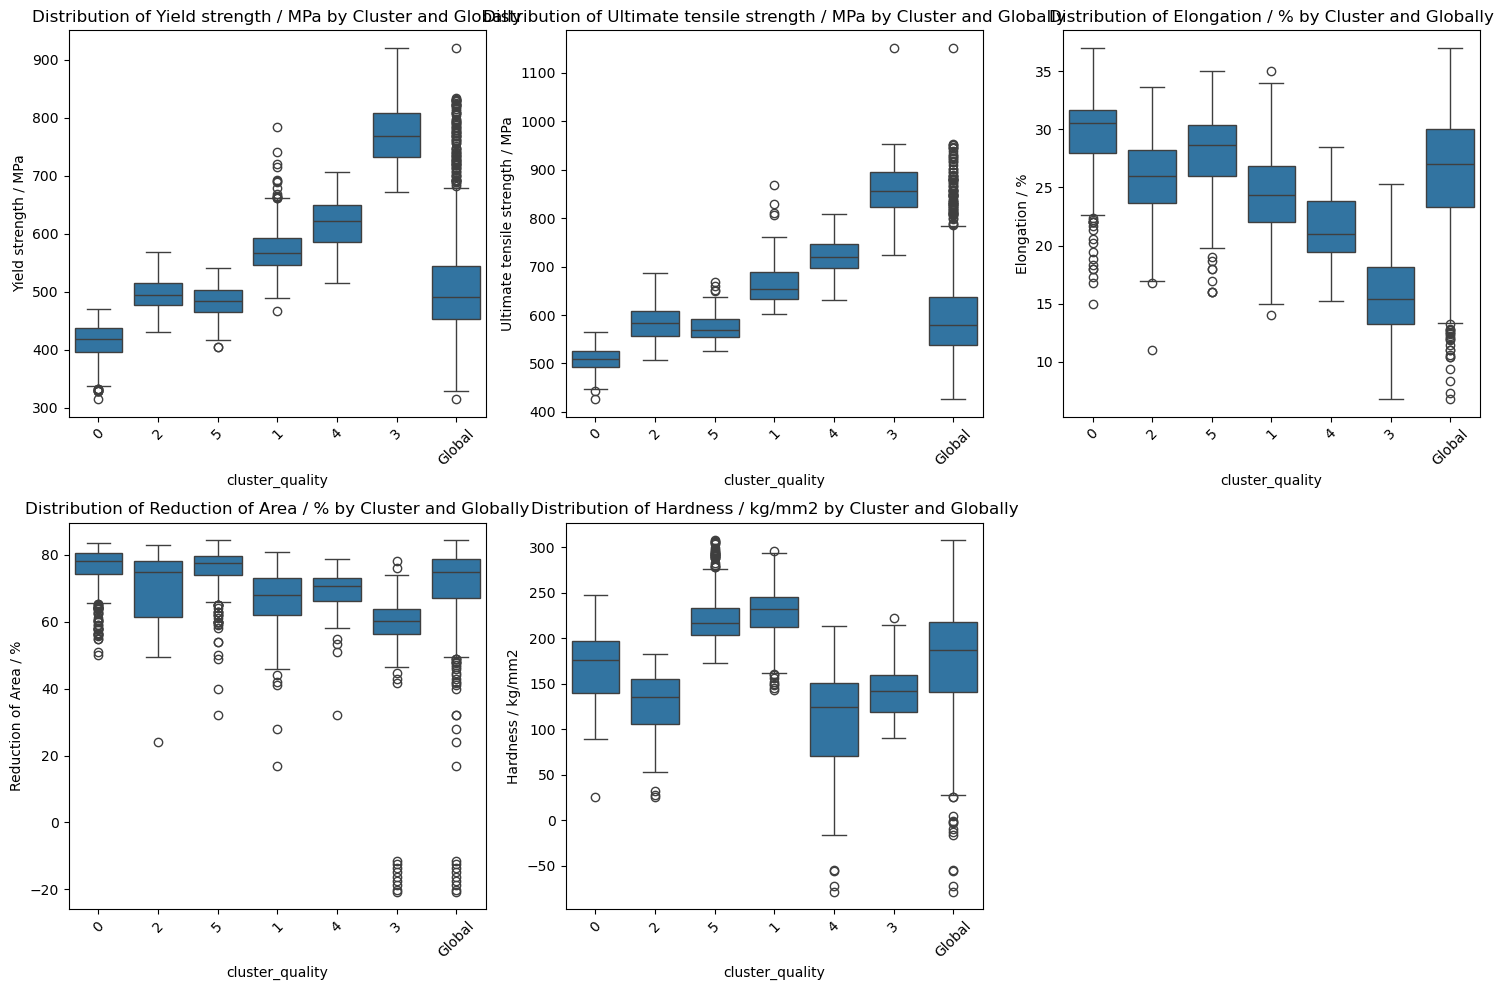

In [1226]:

import seaborn as sns
import matplotlib.pyplot as plt

# Ajouter une colonne pour la distribution globale
data_processed['cluster_global'] = 'Global'

# Combiner les colonnes 'cluster_quality' et 'cluster_global' pour obtenir une vue complète
data_with_global = pd.concat([data_processed[['cluster_quality'] + variables], 
                              data_processed[['cluster_global'] + variables].rename(columns={'cluster_global': 'cluster_quality'})])

# Liste des variables d'intérêt
variables = ['Yield strength / MPa', 'Ultimate tensile strength / MPa',
             'Elongation / %', 'Reduction of Area / %', 'Hardness / kg/mm2']

# Création de sous-plots pour chaque variable
plt.figure(figsize=(15, 10))

for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='cluster_quality', y=var, data=data_with_global)
    plt.title(f'Distribution of {var} by Cluster and Globally')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
